# Following trends on Twitter

[1. Abstract](#Abstract)

[2. Exploratory data analysis](#Exploratory-data-analysis)

[3. Topic Modeling using LDA](#A-very-simple-Topic-Modeling-using-LDA)

[4. Example of the pipeline](#Example-of-the-pipeline-that-we-will-follow-for-the-LDA-algorithm)

[5. Milestone 3](#Milestone-3:-the-data-story)

# Abstract


We realiazed that it will be hard to achieve the goal stated in milestone 1(detecting fake news). The problem is that we couldn't find a way to define fake news. And also the twitter dataset is not what we expected it to be. For example it doesn't contain the number of times a tweet has been retweeted, the geographical location, number of likes ... So we decided to go in a different, more feasable direction, which is following the process of creating and spreading trends on Twitter. Trying to find patterns between trends and users. 

In [1]:
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from pyspark.sql import *
from pyspark import SparkContext, SQLContext
from pyspark.ml.feature import *
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.sql import functions as F
import pickle
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
%matplotlib inline  

#### Read data

> Each data entry has 5 fields:
     - language: language of the user 
     - id: id of the user
     - date: date when the tweet was published
     - username: username of the user
     - content: the tweet
     
Given that for the moment we consider only rows that have all 5 fields we don't have to deal with missing values.
     

In [2]:
sqlContext = SQLContext(sc)
data = sc.textFile("/datasets/tweets-leon")

# Exploratory data analysis

> 1 We will first clean the data and select only a subset that is useful for this project:
    - keep only the tweets that have all 5 fields
    - remove urls from the content
    - remove emojis
    - remove punctuation 
    - remove stopwords
    - apply lemmatization 
    - keep only english, spanish and french tweets
    - ...

In [3]:
frist_tweet = data.first()
frist_tweet.split('\t')[2]

u'Sat Jun 15 18:00:01 +0000 2013'

In [24]:
frist_tweet.split('\t')[2].split(' ')[1]

u'Jun'

In [44]:
"""Chose tweets that have exactly 5 components like normal 
         (language, id, date, username, content)"""

def selection_tweet(tweet):
    array = tweet.split("\t")
    if (array[0] == 'en' and array[2][-4:]=='2014'):
        if ('RT' not in array[4]):
            return True
    return False

In [45]:
"""Remove punctuation, hashtags and urls"""

table = string.maketrans("","")
def punctuation(s):
    s = re.sub(r"@\S+", "", s)     #mention
    s = re.sub(r"http\S+", "", s)  #urls
    s = re.sub(r"#\S+", "", s)     #hashtag
    return s.translate(table, string.punctuation)

In [47]:
"encode tweet by mapping"

def encode_tweet(tweet):
    "Encode UTF-8"
    encoded = [t.encode("utf8") for t in tweet.split("\t")]
    "Remove punctuation and urls"
    encoded[4] = punctuation(encoded[4])
    "Lemmatization"
    encoded[4]= lemmatization(encoded[4])
    "Return id and content of tweet"
    return [encoded[1], encoded[4]]

In [48]:
precessed_data = data.filter(selection_tweet) \
                     .map(encode_tweet)

In [ ]:
hum = precessed_data.first()

Later on using the filter function as done below we will select only a useful subset of the data

In [ ]:
"""remove urls"""

#TODO

In [ ]:
"""remove emojis"""

#TODO

In [ ]:
"""remove punctuation"""

#TODO

In [7]:
"""Lemmatization"""

def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatization(sentence):
    lemmatiser = WordNetLemmatizer()
    tokens_pos = pos_tag(sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    
    return [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]

In [9]:
"""select a subset of the data"""

data = data.filter(selection_tweet)

en_data = data.filter(lambda x : x[:2]=='en')
es_data = data.filter(lambda x : x[:2]=='es')
fr_data = data.filter(lambda x : x[:2]=='fr')

data_2012 = data.filter(lambda tweet : 
                        encode_tweet(tweet)[2][-4:] == '2012')
data_2013 = data.filter(lambda tweet : 
                        encode_tweet(tweet)[2][-4:] == '2013')


In [ ]:
some_fr_tweets = fr_data.take(5)
some_fr_tweets

In [ ]:
some_fr_tweets = [encode_tweet(tweet) for tweet in some_fr_tweets]

In [ ]:
print 'Some french tweets:'
for ind, t in enumerate(some_fr_tweets):
    print ind + 1,')User name:',t[3]
    print '         Tweets:', ((t[4]))
    print '         at:', t[2]
    print 

# A very simple Topic Modeling using LDA

In order to familiarize ourselves with the dataset we started with a very simple approach for topic extraction. For achieving this we will use the Latent Dirichlet allocation algorithm. We first need to build the tf-idf matrix using our data and then then pass it as a parameter to the LDA method. We also need to specify the number of topics to be extracted from the dataset, α(parameter of the Dirichlet prior on the per-document topic distributions) and β(parameter of the Dirichlet prior on the per-topic word distribution). We will determine this values in the next milestone. 

In [ ]:

"""Data in english and encode UTF-8"""
en_data = data.filter(selection_tweet).map(encode_tweet)

"""Take only ID and CONTENT of a tweet"""
tweets = en_data.map(lambda tweet : Row(id=tweet[0], sentence=tweet[1]))

"""Create DF"""
df_tweets = sqlContext.createDataFrame(tweets)

df_tweets.show(3)

In [30]:
"""Tokenization"""
regexTokenizer = RegexTokenizer(inputCol="sentence", outputCol="raw", pattern="\\W")
regexTokenized = regexTokenizer.transform(df_tweets)

regexTokenized.show(3)

+------------------+--------------------+--------------------+
|                id|            sentence|                 raw|
+------------------+--------------------+--------------------+
|345963923251539968|RT @silsilfani: t...|[rt, silsilfani, ...|
|345963923297673217|RT @WhosThisHoe: ...|[rt, whosthishoe,...|
|345963923259924480|Can't stand peopl...|[can, t, stand, p...|
+------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
with open("regexTokenized.pickle", "wb") as f:
    pickle.dump(regexTokenized, f)

In [31]:
"""Remove Stop-words"""
remover = StopWordsRemover(inputCol="raw", outputCol="filtered")
removed_stopwords = remover.transform(regexTokenized)
with open("removed_stopwords.pickle", "wb") as f:
    pickle.dump(removed_stopwords, f)
removed_stopwords.show(3)

+------------------+--------------------+--------------------+--------------------+
|                id|            sentence|                 raw|            filtered|
+------------------+--------------------+--------------------+--------------------+
|345963923251539968|RT @silsilfani: t...|[rt, silsilfani, ...|[rt, silsilfani, ...|
|345963923297673217|RT @WhosThisHoe: ...|[rt, whosthishoe,...|[rt, whosthishoe,...|
|345963923259924480|Can't stand peopl...|[can, t, stand, p...|[t, stand, people...|
+------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
"""apply lemmatization and remove punctuation"""


 Warning: Computation of TF-IDF and LDA take a lot of time (6h on the cluster, we don't know what's happening, why it takes so long ? Could you take a look at our code to see if maybe there is a problem with it). This is the reason why we have an extra python file (LDA.py) to submit to the cluster for the computation. 

In [ ]:
"""TF-IDF"""

cv = CountVectorizer(inputCol="filtered", outputCol="vectors")
count_vectorizer_model = cv.fit(removed_stopwords)
tf = count_vectorizer_model.transform(removed_stopwords)

idf = IDF(inputCol="vectors", outputCol="tfidf")
idfModel = idf.fit(tf)
tfidf = idfModel.transform(tf)

tfidf.show(3)

In [ ]:
"""Topics extraction with LDA"""

nbTopics=100
n_terms=15

corpus = tfidf.select(F.col('id').cast("long"), 'tfidf').rdd.map(lambda x: [x[0], x[1]])
ldaModel = LDA.train(corpus, k=nbTopics)


topics = ldaModel.describeTopics(maxTermsPerTopic=n_terms)
vocabulary = count_vectorizer_model.vocabulary

"""Store result"""
with open("topics.pickle", "wb") as f:
    pickle.dump(topics, f)
with open("vocabulary.pickle", "wb") as f:
    pickle.dump(vocabulary, f)   

In [ ]:
"""Load result computed from cluster"""

with open("topics.pickle", "rb") as f:
    topics = pickle.load(f)
    
with open("vocabulary.pickle", "rb") as f:
    vocabulary = pickle.load(f)

In [ ]:
for topic in range(len(topics)):
    print("topic {} : ".format(topic))
    words = topics[topic][0]
    scores = topics[topic][1]
    for word in range(len(words)):
        print(vocabulary[words[word]], "-", scores[word])

In [ ]:
topics = sc.textFile("/user/khau/topics.pickle")
vocabulary = sc.textFile("/user/khau/vocabulary.pickle")

In [5]:
def plot_topics(topics, vocabulary, nbTopics, n_terms):
    topic_scores = [x[1] for x in topics] #all scores
    max_score = np.max(topic_scores)
    nbColsPlot = 4
    MAGIC_NUMBER = 50
    fontsize_init = MAGIC_NUMBER / max_score

    for topic in range(len(topics)):
        plt.subplot(1, nbColsPlot, topic%4 + 1)
        plt.ylim(0, num_top_words + 0.5)
        plt.xticks([]) 
        plt.yticks([])
        plt.title('Topic #{}'.format(topic+1))
        words = topics[topic][0]
        scores = topics[topic][1]
        for word in range(len(words)):
            font_size = fontsize_init*scores[word]
            font_size = min(font_size, MAGIC_NUMBER)
            plt.text(0.05, num_top_words-word-0.5, vocabulary[words[word]], fontsize=font_size) 
    plt.tight_layout()
    plt.show()
    
plot_topics(topics, vocabulary, nbTopics=20, n_terms=10)

NameError: name 'topics' is not defined

# Example of the pipeline that we will follow for the LDA algorithm

In [4]:
# random dataframe 
sentenceDataFrame = sqlContext.createDataFrame([
    (0, "Hi I heard about Spark"),
    (1, "I wish Java could use case spark classes"),
    (2, "Logistic,regression,models,are,neat"),
    (3, "I want a coffee before going bed to bed "),
    (4, "Today is a big big day day !!!")
], ["id", "sentence"])

# tokenization
regexTokenizer = RegexTokenizer(inputCol="sentence", outputCol="words", pattern="\\W")
regexTokenized = regexTokenizer.transform(sentenceDataFrame)
#with open("regexTokenized.pickle", "wb") as f:
#    pickle.dump(regexTokenized, f)
# remove stop words
#regexTokenized.save('aaaa')
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
removed = remover.transform(regexTokenized)

#removed.save('oooo')
#with open("removed_stopwords.pickle", "wb") as f:
#    pickle.dump(removed, f)
# create the tf-idf matrix
a = removed.drop('words')
a = a.drop('sentence')

cv = CountVectorizer(inputCol="filtered", outputCol="vectors")
count_vectorizer_model = cv.fit(a)
tf = count_vectorizer_model.transform(a)
vocabulary = count_vectorizer_model.vocabulary  

b = tf.drop('filtered')

idf = IDF(inputCol="vectors", outputCol="tfidf")
idfModel = idf.fit(b)
tfidf = idfModel.transform(b)

c = tfidf.drop('vectors')

#tfidf.save('cccc')
#with open("tfidf.pickle", "wb") as f:
#    pickle.dump(tfidf, f)

# initialize parameters
nbTopics=3
#n_terms=3

corpus = tfidf.select(F.col('id').cast("long"), 'tfidf').rdd.map(lambda x: [x[0], x[1]])
ldaModel = LDA.train(corpus, k=nbTopics)
# extraction vocabulary


#ldaModel.save(sc,'dddd')
#with open("vocabulary.pickle", "wb") as f:
#    pickle.dump(ldaModel, f)    
# extracting topics
#topics = ldaModel.describeTopics(maxTermsPerTopic=n_terms)
#with open("topics.pickle", "wb") as f:
#    pickle.dump(topics, f)

        
#plot_topics(topics, vocabulary, nbTopics=3, n_terms=2)        

In [4]:
ldaModel.save(sc, 'somethingelse')

In [15]:
sameModel = LDAModel.load(sc, 'somethingelse')

In [17]:
somethings.write.json("somethings.txt")

In [5]:
c.show()

+---+--------------------+
| id|               tfidf|
+---+--------------------+
|  0|(19,[3,7,15],[0.6...|
|  1|(19,[3,5,12,16,17...|
|  2|(19,[4,8,11,13],[...|
|  3|(19,[1,6,10,14],[...|
|  4|(19,[0,2,9],[2.19...|
+---+--------------------+



In [26]:
vocabulary = sc.textFile("/user/khau/vocabulary.pickle")

262144

In [19]:
tfidf.drop('sentence').show()

+---+--------------------+--------------------+--------------------+--------------------+
| id|               words|            filtered|             vectors|               tfidf|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|[hi, i, heard, ab...|  [hi, heard, spark]|(19,[3,7,15],[1.0...|(19,[3,7,15],[0.6...|
|  1|[i, wish, java, c...|[wish, java, use,...|(19,[3,5,12,16,17...|(19,[3,5,12,16,17...|
|  2|[logistic, regres...|[logistic, regres...|(19,[4,8,11,13],[...|(19,[4,8,11,13],[...|
|  3|[i, want, a, coff...|[want, coffee, go...|(19,[1,6,10,14],[...|(19,[1,6,10,14],[...|
|  4|[today, is, a, bi...|[today, big, big,...|(19,[0,2,9],[2.0,...|(19,[0,2,9],[2.19...|
+---+--------------------+--------------------+--------------------+--------------------+



In [16]:
tfidf.drop('sentence').show()


+---+--------------------+--------------------+--------------------+--------------------+
| id|               words|            filtered|             vectors|               tfidf|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|[hi, i, heard, ab...|  [hi, heard, spark]|(19,[3,7,15],[1.0...|(19,[3,7,15],[0.6...|
|  1|[i, wish, java, c...|[wish, java, use,...|(19,[3,5,12,16,17...|(19,[3,5,12,16,17...|
|  2|[logistic, regres...|[logistic, regres...|(19,[4,8,11,13],[...|(19,[4,8,11,13],[...|
|  3|[i, want, a, coff...|[want, coffee, go...|(19,[1,6,10,14],[...|(19,[1,6,10,14],[...|
|  4|[today, is, a, bi...|[today, big, big,...|(19,[0,2,9],[2.0,...|(19,[0,2,9],[2.19...|
+---+--------------------+--------------------+--------------------+--------------------+



In [39]:
term_counts = sqlContext.createDataFrame(a.map(lambda wc: Row(term=wc[0], count=wc[1])))

In [40]:
term_counts.show()

+-----+----------+
|count|      term|
+-----+----------+
|    2|       big|
|    2|     spark|
|    2|       day|
|    2|       bed|
|    1|      case|
|    1|    models|
|    1|     heard|
|    1|      wish|
|    1|    coffee|
|    1|       use|
|    1|   classes|
|    1|     going|
|    1|        hi|
|    1|      neat|
|    1|      java|
|    1|regression|
|    1|     today|
|    1|  logistic|
|    1|      want|
+-----+----------+



In [23]:
#sqlContext.createDataFrame('/user/khau/regexTokenized')
a = sqlContext.read.load('/user/khau/cccc')
a.show(3)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|            sentence|               words|            filtered|             vectors|               tfidf|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|Hi I heard about ...|[hi, i, heard, ab...|  [hi, heard, spark]|(19,[4,14,15],[1....|(19,[4,14,15],[1....|
|  1|I wish Java could...|[i, wish, java, c...|[wish, java, use,...|(19,[2,10,16,17,1...|(19,[2,10,16,17,1...|
|  2|Logistic,regressi...|[logistic, regres...|[logistic, regres...|(19,[1,5,9,11],[1...|(19,[1,5,9,11],[1...|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



# Milestone 3: the data story

In [ ]:
"""Play around with the parameters of the LDA algorithm in order to find the optimal values for α and β. """

#TODO

In [ ]:
"""repeat the same technique for spanish and french"""

#TODO

In [ ]:
"""algorithm for detecting the top trends"""

#TODO

In [ ]:
"""trying to find patterns between trends"""

#TODO

In [ ]:
"""analyse the data per user 
    ex. which topics he tweets most about ? 
        does it change over time ? """

#TODO

In [ ]:
"""find top users that were the most mentioned by somebody else"""

#TODO

In [ ]:
"""visualization of the result(per language, per month ...)"""

#TODO

# Lam lai tu dau


In [2]:
"Load data"

data = sc.textFile("/datasets/tweets-leon")

In [3]:
"""Select tweet by filtering"""
def selection_tweet(tweet):
    array = tweet.split("\t")
    if (len(array)==5):
        if (array[0] == 'en' and array[2][-4:]=='2014'):
            return True
    return False

data_2014 = data.filter(selection_tweet)

# 1) Some statistics about data (2014)

In [ ]:
"spark-submit for the computation (stats.py)"
tweet_count = data_2014.map(lambda tweet: (tweet.split('\t')[2].split(' ')[1], 1)) \
                       .reduceByKey(lambda a, b: a + b) \
                       .sortBy(lambda wc: -wc[1])

counts = sqlContext.createDataFrame(tweet_count.map(lambda wc: Row(month=wc[0], count=wc[1])))

counts.show()

# save to json
counts.write.json("tweets_count.txt")

In [51]:
tweets_count = sc.textFile('/user/khau/tweets_count.txt')
tweets_count = tweets_count.collect()
tweets_count

[u'{"count":360042745,"month":"Jan"}',
 u'{"count":292583603,"month":"Dec"}',
 u'{"count":274942295,"month":"Mar"}',
 u'{"count":247174867,"month":"Feb"}',
 u'{"count":212186528,"month":"Jun"}',
 u'{"count":158177560,"month":"Apr"}',
 u'{"count":88703791,"month":"May"}',
 u'{"count":43743119,"month":"Aug"}',
 u'{"count":41006717,"month":"Nov"}',
 u'{"count":40601380,"month":"Oct"}',
 u'{"count":40263598,"month":"Sep"}',
 u'{"count":18825682,"month":"Jul"}']

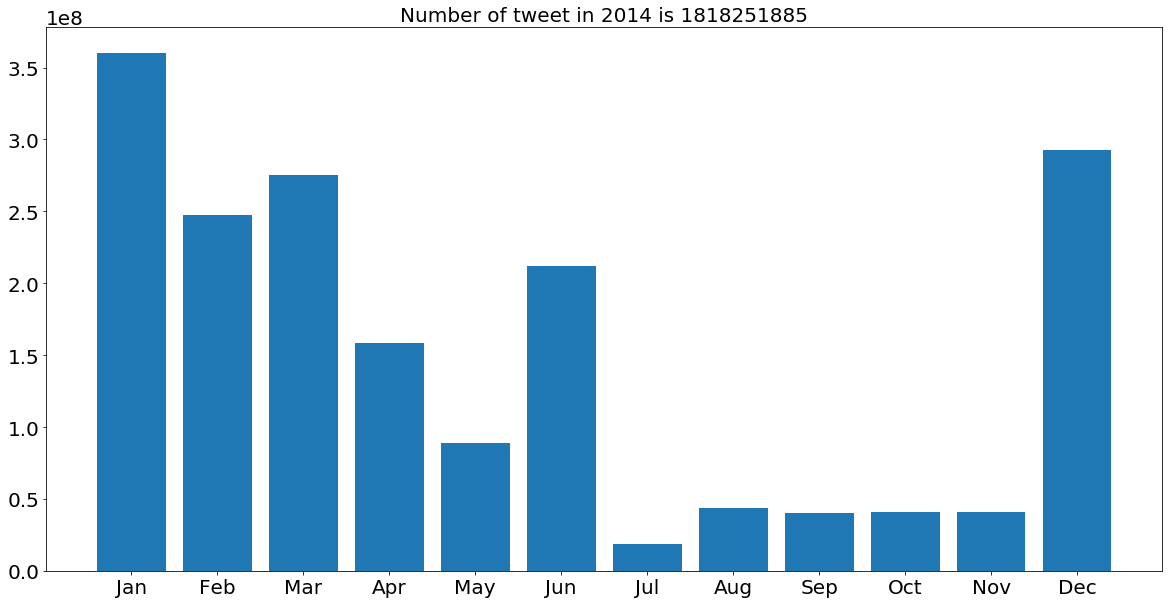

In [50]:
months = ['Jan', 'Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
counts = [360042745, 247174867, 274942295, 158177560,  88703791, 212186528,
          18825682, 43743119, 40263598, 40601380,  41006717, 292583603]
indexes = np.arange(12) + 1
SMALL_SIZE = 20
plt.rc('font', size=SMALL_SIZE)
plt.figure(figsize=(20,10))
plt.bar(indexes, counts)
plt.xticks(indexes, months)
plt.title('Number of english tweets in 2014 (on this dataset) is '+ str(np.sum(counts)))
plt.show()

# 2) Syntactical analysis

## A) Hashtag clustering

In [20]:
def extract_hash_tags(tweet):
    encoded = [t.encode("utf-8") for t in tweet.split("\t")]
    return [(part[1:], 1) for part in encoded[4].split() if part.startswith('#')]

In [ ]:
"spark-submit for the computation (HTcount.py)"

hashtags = data_2014.map(extract_hash_tags)

hashtag_counts = hashtags.flatMap(extract_hash_tags) \
                         .reduceByKey(lambda a,b : a + b)\
                         .sortBy(lambda wc: -wc[1])
        
hashtag_counts = sqlContext.createDataFrame(hashtags.map(lambda wc: Row(hashtag=wc[0], count=wc[1])))

hashtag_counts.show()

# save to json
hashtag_counts.write.json("hashtag_counts.txt")

In [4]:
hashtag_counts = sc.textFile('/user/khau/hashtag_counts.txt')
hashtag_counts.take(5)

[u'{"count":4461004,"hashtag":"gameinsight"}',
 u'{"count":2352313,"hashtag":"KCA"}',
 u'{"count":1987323,"hashtag":"openfollow"}',
 u'{"count":1881818,"hashtag":"androidgames,"}',
 u'{"count":1823624,"hashtag":"MTVStars"}']

In [5]:
top_hashtags = hashtag_counts.map(json.loads)
nbHashTags   = top_hashtags.map(lambda x : x['count']) \
                           .sum()

In [6]:
hashtags_frequency = top_hashtags.take(1000)
hashtags_frequency = [(ht['count']/float(nbHashTags) , ht['hashtag'].encode('utf-8')) for ht in hashtags_frequency]

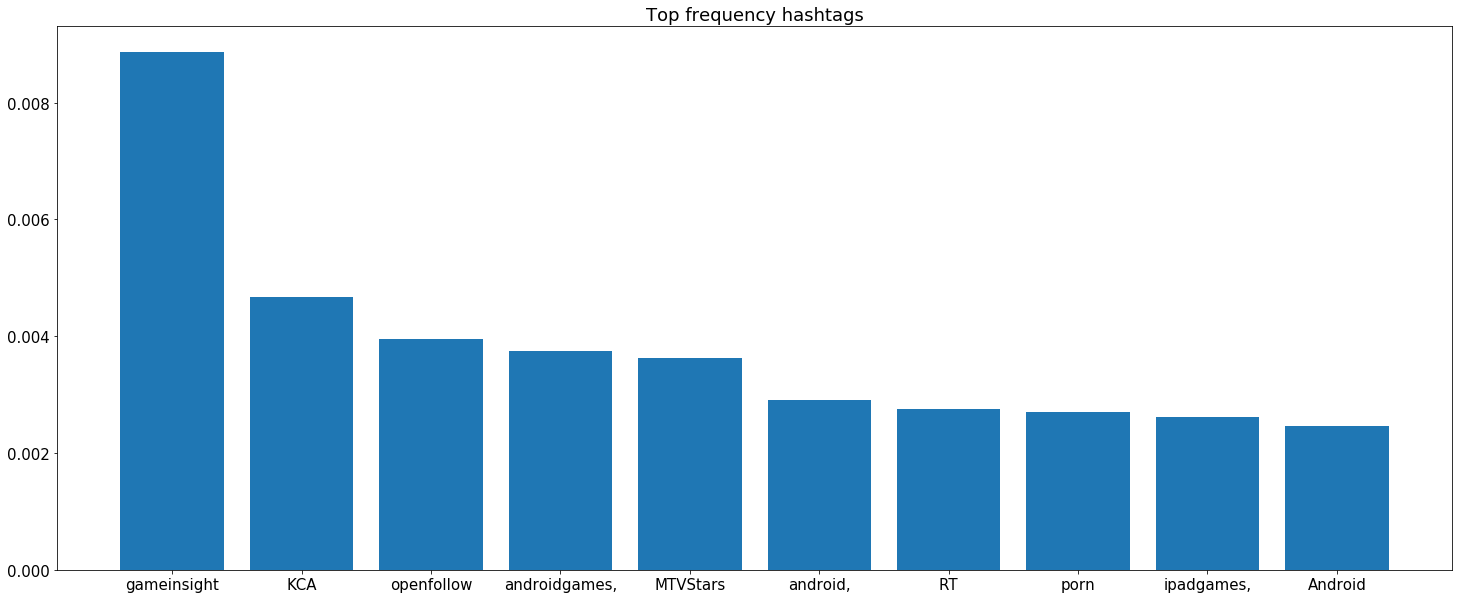

In [19]:
nbTake = 10
indexes = np.arange(nbTake) + 1
plt.rc('font', size=15)
plt.figure(figsize=(25,10))
x = [ elem[0] for elem in hashtags_frequency[:nbTake]]
y = [ elem[1] for elem in hashtags_frequency[:nbTake]]
plt.bar(indexes, x)
plt.xticks(indexes, y)
plt.title('Top frequency hashtags in 2014')
plt.show()

## B) Top terms frequencies

In [28]:
"""Remove punctuation, hashtags and urls"""

table = string.maketrans("","")
def punctuation(s):
    s = re.sub(r"@\S+", "", s)     #mention
    s = re.sub(r"http\S+", "", s)  #urls
    s = re.sub(r"#\S+", "", s)     #hashtag
    return s.translate(table, string.punctuation)


"Encode tweet by mapping"

def encode_tweet(tweet):
    "Encode UTF-8"
    encoded = [t.encode("utf8") for t in tweet.split("\t")]
    "Remove punctuation, hashtags and urls"
    encoded[4] = punctuation(encoded[4])
    "Return id and content of tweet"
    return encoded[4]


In [ ]:
"spark-submit for the computation (stopwords.py)"

terms = data_2014.map(encode_tweet) \
                 .map(lambda tweet : Row(sentence=tweet))
df_terms = sqlContext.createDataFrame(terms)

"""Remove Stop-words"""
remover = StopWordsRemover(inputCol="sentence", outputCol="filtered")
removed_stopwords = remover.transform(df_terms)


In [2]:
"spark-submit for the computation (count.py)"

removed_stopwords = sqlContext.read.load('removed_stopwords')

filtered_column = removed_stopwords.map(lambda x : x['filtered'])

count_rrd = filtered_column.flatMap(lambda x : x) \
                           .map(lambda x : (x, 1)) \
                           .reduceByKey(lambda a, b: a + b) \
                           .sortBy(lambda wc: -wc[1])

term_counts = sqlContext.createDataFrame(count_rrd.map(lambda wc: Row(term=wc[0], count=wc[1])))

# save to json
term_counts.write.json("term_counts.txt")

In [27]:
term_counts = sc.textFile('/user/khau/term_counts.txt')

In [46]:
"""Stop words of spark StopWordsRemover is not good !!!"""
term_counts.take(10)

[u'{"count":2902247457,"term":""}',
 u'{"count":612151851,"term":"RT"}',
 u'{"count":80808962,"term":"Im"}',
 u'{"count":74784471,"term":"like"}',
 u'{"count":71374469,"term":"just"}',
 u'{"count":54681848,"term":"dont"}',
 u'{"count":51253331,"term":"amp"}',
 u'{"count":50624335,"term":"love"}',
 u'{"count":46807769,"term":"\xe2\x80\x9c"}',
 u'{"count":40131898,"term":"know"}']

In [103]:
twitter_stopwords = open('data/twitter-stopwords.txt', 'r').read().split(',')
stopwords = open('data/stopwords.txt','r').read().split('\n')
stopwords += twitter_stopwords
def twitter_stop_words(x):
    if x['term'].encode('utf-8').lower() in stopwords:
        return False
    return True

In [133]:
top_terms = term_counts.map(json.loads)
filtered_terms = top_terms.filter(twitter_stop_words)
top_filtered_terms = filtered_terms.take(15)


In [134]:
top_filtered_terms = [(x['count'], x['term'].encode('utf-8')) for x in top_filtered_terms]
top_filtered_terms

[(51253331, 'amp'),
 (46807769, '\xc3\xa2\xc2\x80\xc2\x9c'),
 (40131898, 'know'),
 (33739884, 'u'),
 (30057618, 'new'),
 (25474031, 'need'),
 (25173291, 'really'),
 (22763853, '2'),
 (20650215, 'going'),
 (19022144, 'best'),
 (17343020, 'say'),
 (15772060, 'way'),
 (15575424, 'n'),
 (15199068, '3'),
 (14885292, 'better')]

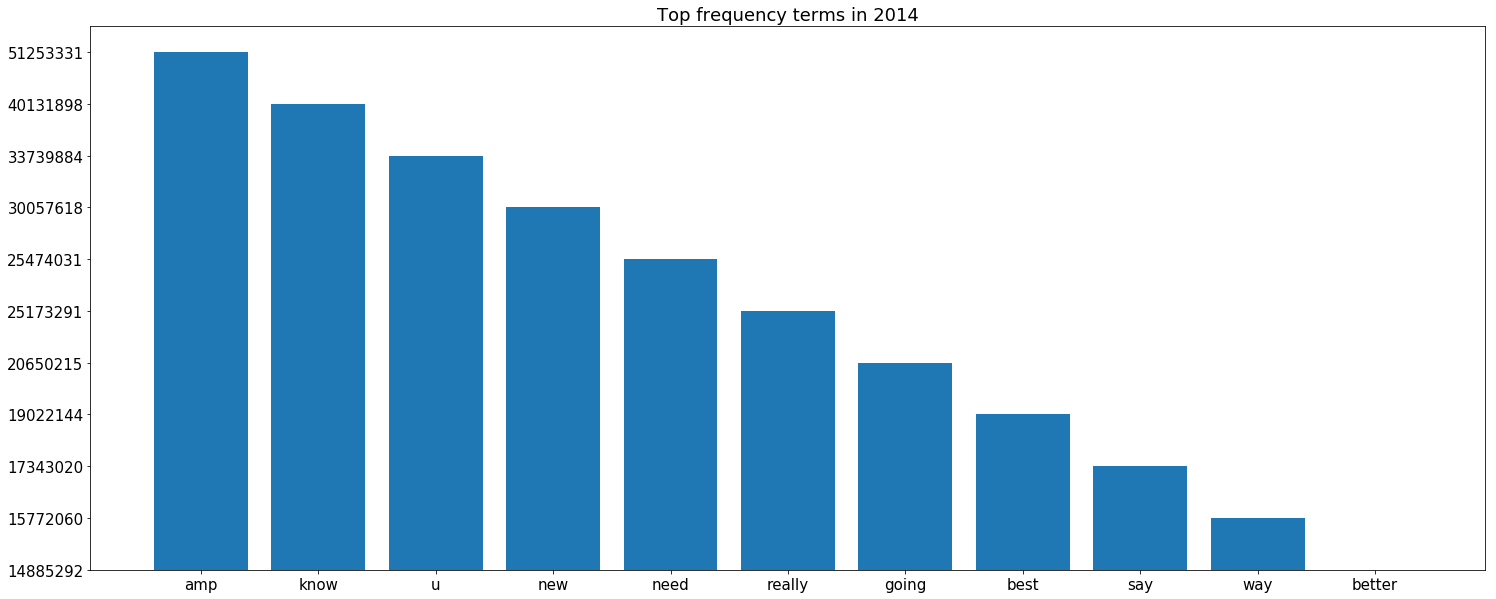

In [136]:
index_meaningful = [0, 2,3,4,5,6,8,9,10,11,14]
top_filtered_terms = np.array(top_filtered_terms)[index_meaningful]
indexes = np.arange(11) + 1
plt.rc('font', size=15)
plt.figure(figsize=(25,10))
x = [elem[0] for elem in top_filtered_terms]
y = [elem[1] for elem in top_filtered_terms]
plt.bar(indexes, x)
plt.xticks(indexes, y)
plt.title('Top frequency terms in 2014')
plt.show()

## C) Co-occurrence

# 3) Semantic Analysis

In [ ]:
"Code submit to cluster for the computation"

"Load removed stopwords"
removed_stopwords = sqlContext.read.load('removed_stopwords')
truncate_df = removed_stopwords.drop('sentence')

"""TF"""
cv = CountVectorizer(inputCol="filtered", outputCol="vectors", minDF=.2)
count_vectorizer_model = cv.fit(truncate_df)
tf = count_vectorizer_model.transform(truncate_df)

vocabulary = count_vectorizer_model.vocabulary
with open("vocabulary.pickle", "wb") as f:
    pickle.dump(vocabulary, f)

truncate_df = tf.drop('filtered')
truncate_df.save('tf', mode='overwrite')

In [ ]:
tf = sqlContext.read.load('tf')
tf.show(3)